# The Viola-Jones Algorithm

In [553]:
%matplotlib inline

import os
import tarfile
import shutil
import hashlib
import glob
import random
from typing import *

import requests
from PIL import Image, ImageOps
import numpy as np
from sklearn.metrics import *

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette('muted')

Our test image will be a colored photo of the fifth Solvay Conference in 1927 ([image source](https://rarehistoricalphotos.com/solvay-conference-probably-intelligent-picture-ever-taken-1927/)), depicting, from front to back and left to right:

- Irving Langmuir, Max Planck, Marie Curie, Hendrik Lorentz, Albert Einstein, Paul Langevin, Charles-Eugène Guye, Charles Thomson Rees Wilson and Owen Richardson in the first row,
- Peter Debye, Martin Knudsen, William Lawrence Bragg, Hendrik Anthony Kramers, Paul Dirac, Arthur Compton, Louis de Broglie, Max Born and Niels Bohr in the second row, as well as
- Auguste Piccard, Émile Henriot, Paul Ehrenfest, Édouard Herzen, Théophile de Donder, Erwin Schrödinger, Jules-Émile Verschaffelt, Wolfgang Pauli, Werner Heisenberg, Ralph Fowler and Léon Brillouin in the back.

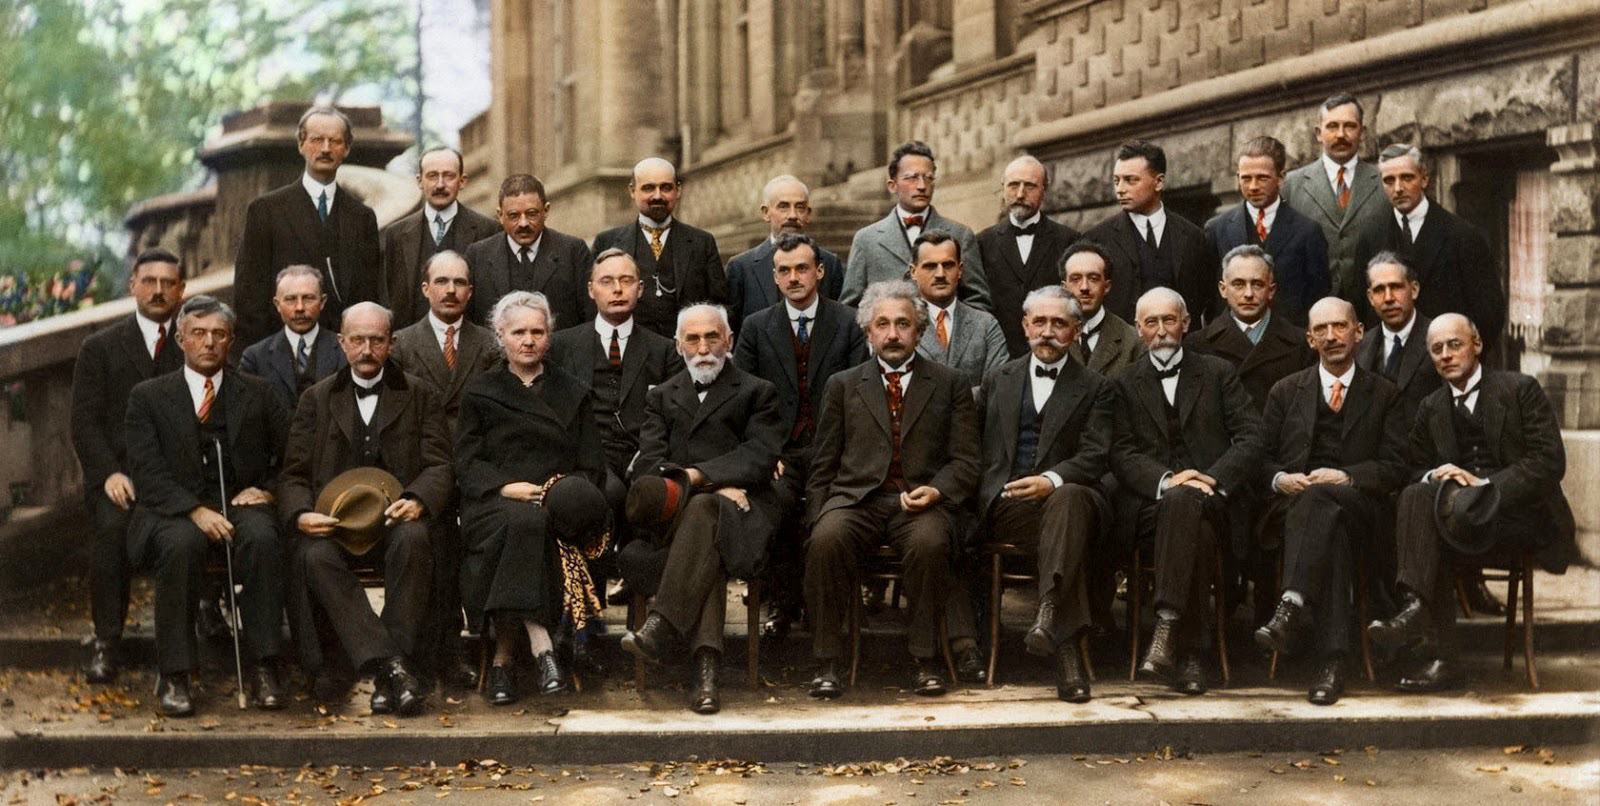

In [65]:
original_image_path = "images/solvay-conference.jpg"
original_image = Image.open(original_image_path)
original_image

Obviously, any other image would have done just as well.

In the original paper [Rapid object detection using a boosted cascade of simple features](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.10.6807), Viola and Jones work with images of size $382 \times 288$. We will now reduce the image size accordingly.

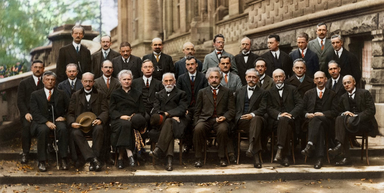

In [67]:
target_size = (384, 288)
thumbnail_image = original_image.copy()
thumbnail_image.thumbnail(target_size, Image.ANTIALIAS)
thumbnail_image

For further processing, we will also convert the image to a NumPy array; in order to display it we will then need to convert it back again.

In [48]:
def to_float_array(img: Image.Image) -> np.ndarray:
    return np.array(img).astype(np.float32) / 255.

def to_image(values: np.ndarray) -> Image.Image:
    return Image.fromarray(np.uint8(values * 255.))

Let's convert the values now.

In [68]:
original = to_float_array(thumbnail_image)

print('Original value range: {0} .. {1}'.format(original.min(), original.max()))

Original value range: 0.0 .. 1.0


## Grayscale conversion

We assume that color information are of no benefit for the task of face detection, which is why we will discard them. Kanan and Cottrell compare different methods of grayscale conversion with respect to recognition tasks in their 2012 paper [Color-to-Grayscale: Does the Method Matter in Image Recognition?](http://tdlc.ucsd.edu/SV2013/Kanan_Cottrell_PLOS_Color_2012.pdf) ([DOI](https://doi.org/10.1371/journal.pone.0029740)). They find that for face detection tasks, the _Gleam_ conversion is almost always optimal. In contrast to a simple _Intensity_ conversion

$$
\mathcal{G}_{Intensity} \leftarrow \frac{1}{3}\left(R + G + B\right),
$$

Gleam uses gamma corrected channels

$$
\mathcal{G}_{Gleam} \leftarrow \frac{1}{3}\left(R' + G' + B'\right)
$$

where

$$
t' = \Gamma(t) = t^{1/2.2}.
$$

There the constant $2.2$ is a common choice ([Wikipedia](https://en.wikipedia.org/wiki/Gamma_correction)), yet an somewhat arbitrary one, and finding an optimal value by means of hyperparameter optimization is suggested in the paper. For the moment, it'll do.

In [8]:
def gamma(values: np.ndarray, coeff: float=2.2) -> np.ndarray:
    return values**(1./coeff)

In [45]:
def gleam(values: np.ndarray) -> np.ndarray:
    return np.sum(gamma(values), axis=2) / values.shape[2]

We now convert the image.

In [69]:
grayscale = gleam(original)

print('Grayscale value range: {0} .. {1}'.format(grayscale.min(), grayscale.max()))

Grayscale value range: 0.0 .. 0.9862089157104492


Visually inspecting the outcome shows that the image appears to be brighter than before. This is due to the gamma conversion and also specifically mentioned in the paper.

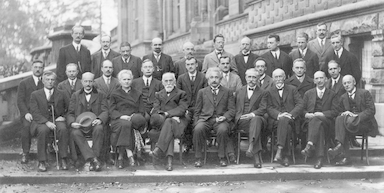

In [70]:
to_image(grayscale)

## Base features

Viola and Jones define four base Haar-like features; two two-rectangle features, one three-rectangle one and a four-rectangle features. They can be understood as follows:

$$
\begin{align}
\mathcal{F}_{2,h} &= \begin{bmatrix}
    1 & -1
    \end{bmatrix} \\
\mathcal{F}_{2,v} &= \begin{bmatrix}
    -1 \\ 1
    \end{bmatrix} \\
\mathcal{F}_{3,h} &= \begin{bmatrix}
    -1 & 1 & -1
    \end{bmatrix} \\
\mathcal{F}_{4} &= \begin{bmatrix}
    1 & -1 \\
    -1 & 1
    \end{bmatrix}
\end{align}.
$$

When overlaying these features on the (original) image, values corresponding to a coefficient of $1$ are added, whereas values corresponding to a $-1$ are subtracted. The papers by Viola and Jones are not clear in this regard, as pointed out by [this StackOverflow question](https://stackoverflow.com/questions/1707620/viola-jones-face-detection-claims-180k-features). We will consider a fifth feature,

$$
\begin{align}
\mathcal{F}_{3,v} &= \begin{bmatrix}
    -1 \\ 1 \\ -1
    \end{bmatrix}
\end{align}.
$$

Rather than applying these features as-is, actual kernels are derived by scaling and positioning these features in a detection window of $24 \times 24$ pixels. This, for example, is a valid kernel derived from the $\mathcal{F}_{2,h}$ feature:

$$
\begin{bmatrix}
    0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  \\
    0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  \\
    0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  \\
    0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  \\
%    
    0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 1 & 1  &  1 & 1 & -1 & -1  &  -1 & -1 & 0 & 0  &  0 & 0 & 0 & 0  \\
    0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 1 & 1  &  1 & 1 & -1 & -1  &  -1 & -1 & 0 & 0  &  0 & 0 & 0 & 0  \\
    0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 1 & 1  &  1 & 1 & -1 & -1  &  -1 & -1 & 0 & 0  &  0 & 0 & 0 & 0  \\
    0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 1 & 1  &  1 & 1 & -1 & -1  &  -1 & -1 & 0 & 0  &  0 & 0 & 0 & 0  \\
%    
    0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 1 & 1  &  1 & 1 & -1 & -1  &  -1 & -1 & 0 & 0  &  0 & 0 & 0 & 0  \\
    0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 1 & 1  &  1 & 1 & -1 & -1  &  -1 & -1 & 0 & 0  &  0 & 0 & 0 & 0  \\
    0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 1 & 1  &  1 & 1 & -1 & -1  &  -1 & -1 & 0 & 0  &  0 & 0 & 0 & 0  \\
    0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 1 & 1  &  1 & 1 & -1 & -1  &  -1 & -1 & 0 & 0  &  0 & 0 & 0 & 0  \\
%    
    0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 1 & 1  &  1 & 1 & -1 & -1  &  -1 & -1 & 0 & 0  &  0 & 0 & 0 & 0  \\
    0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 1 & 1  &  1 & 1 & -1 & -1  &  -1 & -1 & 0 & 0  &  0 & 0 & 0 & 0  \\
    0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 1 & 1  &  1 & 1 & -1 & -1  &  -1 & -1 & 0 & 0  &  0 & 0 & 0 & 0  \\
    0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 1 & 1  &  1 & 1 & -1 & -1  &  -1 & -1 & 0 & 0  &  0 & 0 & 0 & 0  \\
%    
    0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 1 & 1  &  1 & 1 & -1 & -1  &  -1 & -1 & 0 & 0  &  0 & 0 & 0 & 0  \\
    0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 1 & 1  &  1 & 1 & -1 & -1  &  -1 & -1 & 0 & 0  &  0 & 0 & 0 & 0  \\
    0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 1 & 1  &  1 & 1 & -1 & -1  &  -1 & -1 & 0 & 0  &  0 & 0 & 0 & 0  \\
    0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 1 & 1  &  1 & 1 & -1 & -1  &  -1 & -1 & 0 & 0  &  0 & 0 & 0 & 0
\end{bmatrix}
$$

Assuming that the features can only be scaled by powers of two (due to symmetry), a horizontal two-rectangle feature can have the following 12 valid sizes given a $24$ pixel wide window: 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22 and 24. Since the feature is of height 1, there are 24 possible combinations for the height without violating symmetry.

However, given that we also have to position the feature, not all positions are valid:

- A 2 pixel feature can be positioned at $x$ coordinates $0 \dots 22$, resulting in 23 possible combinations.
- A 24 pixel feature can be only positioned at $x$ coordinate $0$, resulting in 1 possible combination.
- A 22 pixel feature can be positioned at $x$ coordinates $0, 1, 2$, resulting in 3 possible combinations.

This yields

$$
n_x\left(width_{feature}\right) = width_{window} - width_{feature} + 1
$$

possible combinations for a specific $width_{feature}$, giving

$$
\begin{align}
    N_{x,2h} &= n_x(2) + n_x(4) + n(6) + \dots + n_x(24) \\
      &= 23 + 21 + 19 \dots + 1 \\
      &= 144
\end{align}
$$

possible combinations for the $x$ position alone. The same reasoning can be applied to the height, which evaluates as

$$
n_y\left(height_{feature}\right) = height_{window} - height_{feature} + 1
$$

and

$$
\begin{align}
    N_{y,2h} &= n_y(1) + n_y(2) + n_y(3) + \dots + n_y(24) \\
      &= 24 + 23 + 22 \dots + 1 \\
      &= 300.
\end{align}
$$

Consequently, the total number of combinations is

$$
\begin{align}
    N_{2h} &= N_{x,2h} \times N_{y,2h} \\
      &= 144 \times 300 \\
      &= 43200.
\end{align}
$$

We can further see that

$$
\begin{align}
    N_{3} &= N_{x,3} \times N_{y,3} \\
      &= 92 \times 300 \\
      &= 27600
\end{align}
$$

and

$$
\begin{align}
    N_{4} &= N_{x,4} \times N_{y,4} \\
      &= 144 \times 144 \\
      &= 20736,
\end{align}
$$

giving a total of

$$
\begin{align}
    N &= 2 \times N_{2} + 2 \times N_{3} + N_{4} \\
      &= 86400 + 55200 + 20736 \\
      &= 162336
\end{align}
$$

combinations (by symmetry of the two-rectangle and three-rectangle features). The original paper claimed a set of "over 180,000" features (likely due the inclusion of trivial, zero-height features), whereas it is stated that the set is "quite large, 45,396" in their 2001 publication [Robust Real-time Object Detection](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.110.4868). As pointed out by [this SO comment](https://stackoverflow.com/questions/1707620/viola-jones-face-detection-claims-180k-features#comment1629929_1711158) however, this was corrected to "quite large, 160,000" in their 2004 publication [Robust Real-Time Face Detection](https://www.researchgate.net/publication/220660094_Robust_Real-Time_Face_Detection) ([PDF](http://www.vision.caltech.edu/html-files/EE148-2005-Spring/pprs/viola04ijcv.pdf)), which matches our findings.

The evaluation of each feature could be done by explicitly instantiating a kernel of the size of the window (here, $24 \times 24$) and folding it with the image under the window. This, however, leads to $24 \times 24 = 576$ multiplications and $24 \times 24 - 1 = 575$ additions per kernel and window, resulting in an exessively high number of operations for an entire image. We can do better using an Integral Image transformation.

## Integral image

An integral image $\mathcal{I}^\ast$ contains the sum (the _discrete_ integral) of all values top and left of a specific point, i.e. each point $i, j$ is determined by the sum

$$
\mathcal{I}^{\ast}_{i, j} = \sum_{x=0}^{i} \sum_{y=0}^{j} \mathcal{I}_{i, j}
$$

of intensity values of the source image $\mathcal{I}$. 

An interesting property of the integral image is that the sum of pixels within individual areas of it can be expressed by only four value accesses, as is shown in the following figure ([source](http://vinsol.com/blog/2016/06/28/computer-vision-face-detection/)):

![Integral image area calculations](images/integral-image.png)

Specifically, the sum of the region $x_{left}, y_{top}, x_{right}, y_{bottom}$ can be determined as

$$
s_{x_{left}, y_{top}, x_{right}, y_{bottom}} = \mathcal{I}^{\ast}_{x_{right}, y_{bottom}}
                                             - \mathcal{I}^{\ast}_{x_{right}, y_{top}}
                                             - \mathcal{I}^{\ast}_{x_{left}, y_{bottom}}
                                             + \mathcal{I}^{\ast}_{x_{top}, y_{left}}.
$$

Conceptually, both the areas $\mathcal{I}^{\ast}_{x_{right}, y_{top}}$ and $\mathcal{I}^{\ast}_{x_{left}, y_{bottom}}$ contain the area $\mathcal{I}^{\ast}_{x_{top}, y_{left}}$, so we need to add it back in.

While simultaneously padding the transformed image with zeros on the top and left edges, we can calculate the integral image like so:

In [311]:
def to_integral(img: np.ndarray) -> np.ndarray:
    integral = np.cumsum(np.cumsum(img, axis=0), axis=1)
    return np.pad(integral, (1, 1), 'constant', constant_values=(0, 0))[:-1, :-1]

integral = to_integral(grayscale)

Since the values of the integral image are not confined to the interval $0..1$ anymore, we first normalize the integral image for viewing purposes. This is how the result looks like:

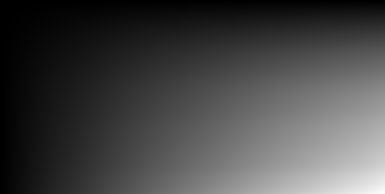

In [312]:
to_image(integral / integral.max())

For easier evaluation, we'll create a helper class `Box` that allows to determine the integral of an image region by means of the integral image:

In [790]:
class Box:
    def __init__(self, left: int, top: int, width: int, height: int):
        assert left + width < 25, f'{left} + {width} >= 25'
        assert top + height < 25, f'{top} + {height} >= 25'
        self._xl, self._yt = left, top
        self._xr, self._yb = left + width, top + height
    
    def __call__(self, integral_image: np.ndarray) -> float:
        a = integral_image[self._yt, self._xl]
        b = integral_image[self._yt, self._xr]
        c = integral_image[self._yb, self._xl]
        d = integral_image[self._yb, self._xr]
        return d - b - c + a

Using the same example as before:

In [727]:
sample_image =  np.array([
    [5, 2, 3, 4, 1], 
    [1, 5, 4, 2, 3],
    [2, 2, 1, 3, 4],
    [3, 5, 6, 4, 5],
    [4, 1, 3, 2, 6]])
sample_integral = to_integral(sample_image)
sample_integral

array([[ 0,  0,  0,  0,  0,  0],
       [ 0,  5,  7, 10, 14, 15],
       [ 0,  6, 13, 20, 26, 30],
       [ 0,  8, 17, 25, 34, 42],
       [ 0, 11, 25, 39, 52, 65],
       [ 0, 15, 30, 47, 62, 81]])

Evaluating the box on the same region does indeed yield the expected result:

In [788]:
sample_box = Box(1, 1, 3, 2)
sample_box(sample_integral)

17

Likewise, area of the lower-right value is just the lower-right value:

In [789]:
Box(4, 4, 1, 1)(sample_integral)

6

# Datasets

In order to train our classifier(s), we need some instances of the class to be found (the faces), and classes to not be found (the background).

In [88]:
dataset_path = 'dataset'

if not os.path.exists(dataset_path):
    os.mkdir(dataset_path)

In order to download the datasets, we're going to use some helper functions:

In [108]:
def download_file(url: str, path: str):
    print('Downloading file ...')
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(path, 'wb') as f:
            r.raw.decode_content = True
            shutil.copyfileobj(r.raw, f)
    print('Download completed.')
    
def md5(path: str, chunk_size: int=65536) -> str:
    hash_md5 = hashlib.md5()
    with open(path, 'rb') as f:
        for chunk in iter(lambda: f.read(chunk_size), b''):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

def untar(file_path: str, dest_path: str):
    print('Extracting file.')
    with tarfile.open(file_path, 'r:gz') as f:
        f.extractall(dest_path)
    print('Extraction completed.')

# Faces

For positive class ("face"), we're going to use the Yearbook Dataset from [A Century of Portraits:
A Visual Historical Record of American High School Yearbooks](https://people.eecs.berkeley.edu/~shiry/projects/yearbooks/yearbooks.html).

> Shiry Ginosar, Kate Rakelly, Sarah Sachs, Brian Yin, Crystal Lee, Alexei A. Efros **A Century of Portraits: A Visual Historical Record of American High School Yearbooks**, in IEEE Transactions on Computational Imaging, Vol. 3, No. 3, September 2017. [PDF](https://people.eecs.berkeley.edu/~shiry/publications/IEEE_yearbooks.pdf), [BibTeX](https://people.eecs.berkeley.edu/~shiry/projects/yearbooks/yearbooks.html#yearbooks_IEEE)

It contains 37,921 pictures of frontal-facing portraits of size $186 \times 171$ where we will assume the face to be in the center.

In [93]:
faces_url = 'https://www.dropbox.com/s/ubjjoo0b2wz4vgz/faces_aligned_small_mirrored_co_aligned_cropped_cleaned.tar.gz?dl=1'
faces_md5 = 'ab853c17ca6630c191457ff1fb16c1a4'

faces_archive = os.path.join(dataset_path, 'faces_aligned_small_mirrored_co_aligned_cropped_cleaned.tar.gz')
faces_dir = os.path.join(dataset_path, 'faces_aligned_small_mirrored_co_aligned_cropped_cleaned')

if not os.path.exists(faces_archive) or md5(faces_archive) != faces_md5:
    download_file(faces_url, faces_archive)

Download complete.


In [110]:
if not os.path.exists(faces_dir):
    untar(faces_archive, dataset_path)

Extracting file.
Extraction completed.


In [115]:
face_image_files = glob.glob(os.path.join(faces_dir, '**', '*.png'), recursive=True)
len(face_image_files)

37921

Let's create some helper function to stitch together images:

In [440]:
def open_face(path: str, resize: bool=True) -> Image.Image:
    img = Image.open(path)
    img = to_image(gamma(to_float_array(img)))
    min_size = np.min(img.size)
    ImageOps.fit(img, (min_size, min_size), Image.ANTIALIAS)
    if resize:
        img = img.resize((24, 24), Image.ANTIALIAS)
    return img.convert('L')

def merge_images(files: Iterable[str], open_fun: Callable, resize: bool=False) -> Image.Image:
    images = [open_fun(f, resize) for f in files]
    sizes = [img.size for img in images]
    collage_width = np.sum([size[0] for size in sizes])
    collage_height = np.max([size[1] for size in sizes])

    result = Image.new('L', (collage_width, collage_height))
    x_offset = 0
    for img, size in zip(images, sizes):
        result.paste(im=img, box=(x_offset, 0))
        x_offset += size[0]
    return result

We can now have a look at a sample of the dataset. Note that the images appear brighter than they would in the original dataset because we're applying gamma correction.

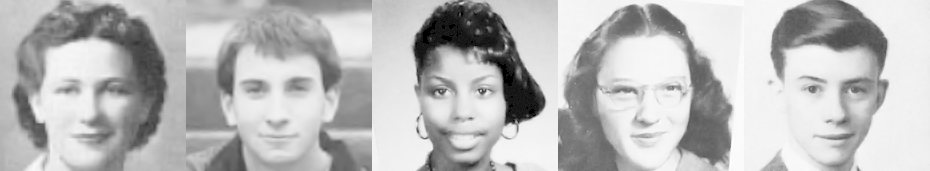

In [420]:
random.seed(1000)
random_face_files = random.sample(face_image_files, 5)
merge_images(random_face_files, open_face)

For comparison, when resized to $24 \times 24$ pixels, this is how it looks like:

In [441]:
merge_images(random_face_files, open_face, True)

## Backgrounds

For the negative class ("not a face") we will make use of the [Stanford Backgrounds Dataset](http://dags.stanford.edu/projects/scenedataset.html) for scene understanding. It contains 715 images of various scenes, from which we will randomly crop regions to be used as background classes.

> S. Gould, R. Fulton, D. Koller. **Decomposing a Scene into Geometric and Semantically Consistent Regions.** Proceedings of International Conference on Computer Vision (ICCV), 2009. [pdf](http://www.stanford.edu/~sgould/papers/iccv09-sceneDecomposition.pdf)

The images are approximately of size $320 \times 240$ and do contain faces in camera-facing poses, but we'll ignore this for the time being. After all, the chance of randomly selecting a valid face that is exactly within the window region is pretty slim.

In [163]:
backgrounds_url = 'http://dags.stanford.edu/data/iccv09Data.tar.gz'
backgrounds_md5 = 'f469cf0ab459d94990edcf756694f4d5'

backgrounds_archive = os.path.join(dataset_path, 'iccv09Data.tar.gz')
backgrounds_dir = os.path.join(dataset_path, 'iccv09Data')

if not os.path.exists(backgrounds_archive) or md5(backgrounds_archive) != faces_md5:
    download_file(backgrounds_url, backgrounds_archive)

Download completed.


In [165]:
if not os.path.exists(backgrounds_dir):
    untar(backgrounds_archive, dataset_path)

Extracting file.
Extraction completed.


In [166]:
background_image_files = glob.glob(os.path.join(backgrounds_dir, '**', '*.jpg'), recursive=True)
len(background_image_files)

715

In [473]:
def random_crop(img: Image.Image) -> Image.Image:
    max_allowed_size = np.min(img.size)
    size = random.randint(24, max_allowed_size)
    max_width = img.size[0] - size - 1
    max_height = img.size[1] - size - 1
    left = 0 if (max_width <= 1)  else random.randint(0, max_width)
    top  = 0 if (max_height <= 1) else random.randint(0, max_height)
    return img.crop((left,top,left+size,top+size))

def open_background(path: str, resize: bool=True) -> Image.Image:
    img = Image.open(path)
    img = to_image(gleam(to_float_array(img)))
    img = random_crop(img)
    if resize:
        img = img.resize((24, 24), Image.ANTIALIAS)
    return img.convert('L')

Due to the random cropping, the results look a bit mixed:

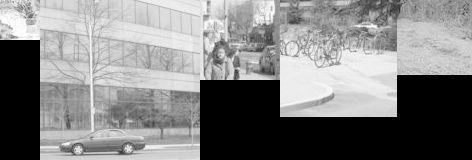

In [460]:
random.seed(1000)
random_background_files = random.sample(background_image_files, 5)
merge_images(random_background_files, open_background)

When resizing, some operation seems to mess with the random state; this doesn't affect the overall functionality of the operation though.

In [461]:
random.seed(1000)
merge_images(random_background_files, open_background, True)

# Training the classifier

Before we can start the training process by means of adaptive boosting, we need to define the features in a way they can actually be evaluated. For this we're going to construct a class for each feature type and then parameterize it according to all possible values, yielding about 160k instances.

In [745]:
class Feature2h:
    def __init__(self, left: int, top: int, width: int, height: int):
        #assert left + width < 24, f'left {left}, width {width}'
        #assert top + height < 24, f'top {top}, height {height}'
        half_width = width // 2
        self._add = Box(left, top, half_width, height)
        self._sub = Box(left + half_width, top, half_width, height)
    
    def __call__(self, integral_image: np.ndarray) -> float:
        return self._add(integral_image) - self._sub(integral_image)

Using the same example as above,

In [725]:
sample_integral

array([[ 0,  0,  0,  0,  0,  0],
       [ 0,  5,  7, 10, 14, 15],
       [ 0,  6, 13, 20, 26, 30],
       [ 0,  8, 17, 25, 34, 42],
       [ 0, 11, 25, 39, 52, 65],
       [ 0, 15, 30, 47, 62, 81]])

we find that an $\mathcal{F}_{2,h}$ of width 2 and height 4 would yield

In [325]:
Box(0, 0, 2, 4)(sample_integral) - Box(2, 0, 2, 4)(sample_integral)

-2

which is precisely the output of our implementation:

In [724]:
Feature2h(0, 0, 4, 4)(sample_integral)

-2

We can also fit the whole detector into the image:

In [750]:
Feature2h(0, 0, 4, 4)(to_integral(np.ones((4, 4))))

0.0

We'll now create the remaining features.

In [753]:
class Feature2v:
    def __init__(self, left: int, top: int, width: int, height: int):
        #assert left + width < 24, f'left {left}, width {width}'
        #assert top + height < 24, f'top {top}, height {height}'
        half_height = height // 2
        self._sub = Box(left, top, width, half_height)
        self._add = Box(left, top + half_height, width, half_height)
    
    def __call__(self, integral_image: np.ndarray) -> float:
        return self._add(integral_image) - self._sub(integral_image)
    
class Feature3h:
    def __init__(self, left: int, top: int, width: int, height: int):
        #assert left + width < 24, f'left {left}, width {width}'
        #assert top + height < 24, f'top {top}, height {height}'
        third_width = width // 3
        self._sub_1 = Box(left, top, third_width, height)
        self._add   = Box(left +   third_width, top, third_width, height)
        self._sub_2 = Box(left + 2*third_width, top, third_width, height)
    
    def __call__(self, integral_image: np.ndarray) -> float:
        return self._add(integral_image) - self._sub_1(integral_image) - self._sub_2(integral_image)
    
class Feature3v:
    def __init__(self, left: int, top: int, width: int, height: int):
        #assert left + width < 24, f'left {left}, width {width}'
        #assert top + height < 24, f'top {top}, height {height}'
        third_height = height // 3
        self._sub_1 = Box(left, top, width, third_height)
        self._add   = Box(left, top +   third_height, width, third_height)
        self._sub_2 = Box(left, top + 2*third_height, width, third_height)
    
    def __call__(self, integral_image: np.ndarray) -> float:
        return self._add(integral_image) - self._sub_1(integral_image) - self._sub_2(integral_image)
    
class Feature4:
    def __init__(self, left: int, top: int, width: int, height: int):
        #assert left + width < 24, f'left {left}, width {width}'
        #assert top + height < 24, f'top {top}, height {height}'
        half_width = width // 2
        half_height = height // 2
        self._add_1 = Box(left, top, half_width, half_height)
        self._sub_1 = Box(left + half_width, top, half_width, half_height)
        self._sub_2 = Box(left, top + half_height, half_width, half_height)
        self._add_2 = Box(left + half_width, top + half_height, half_width, half_height)
    
    def __call__(self, integral_image: np.ndarray) -> float:
        return self._add_1(integral_image) + self._add_2(integral_image) \
             - self._sub_1(integral_image) - self._sub_2(integral_image)

As a sanity check, we're going to evaluate the quadratic feature again on the matrix

$$
\begin{align}
\mathcal{I} = \begin{bmatrix} 0 & 1 \\ 
                              1 & 0 
              \end{bmatrix} \quad \Rightarrow \quad 
\mathcal{I}^\ast = \begin{bmatrix} 0 & 1 \\
                              1 & 2 
               \end{bmatrix}
\end{align}
$$

Since both positions thar are to be subtracted in $\mathcal{F}_{4}$ are 1, we expect a value of -2:

In [327]:
Feature4(0, 0, 2, 2)(to_integral(np.array([[0, 1], 
                                           [1, 0]])))

-2

Similarily the matrix

$$
\begin{align}
\mathcal{I} = \begin{bmatrix} 1 & 0 \\ 
                              0 & 1 
              \end{bmatrix} \quad \Rightarrow \quad 
\mathcal{I}^\ast = \begin{bmatrix} 1 & 1 \\
                                   1 & 2
               \end{bmatrix}
\end{align}
$$

should yield a value of 2, since now all ones are added:

In [718]:
Feature4(0, 0, 2, 2)(to_integral(np.array([[1, 0], 
                                           [0, 1]])))

2

We will now instantiate the feature detectors.

In [780]:
window_width = 24

Size = NamedTuple('Size', [('height', int), ('width', int)])
Location = NamedTuple('Location', [('left', int), ('top', int)])

def possible_position(size: int, window_size: int = window_width) -> Iterable[int]:
    return range(0, window_size - size + 1)

def possible_locations(base_shape: Size, window_size: int = window_width) -> Iterable[Location]:
    width, height = base_shape
    return (Location(left=x, top=y)
            for x in possible_position(width, window_size) 
            for y in possible_position(height, window_size))

def possible_shapes(base_shape: Size, window_size: int = window_width) -> Iterable[Size]:
    base_height, base_width = base_shape
    return (Size(height, width)
            for width in range(base_width, window_size + 1, base_width)
            for height in range(base_height, window_size + 1, base_height))

list(possible_locations((4, 4), 5)), list(possible_shapes((4, 4), 5))

([Location(left=0, top=0),
  Location(left=0, top=1),
  Location(left=1, top=0),
  Location(left=1, top=1)],
 [Size(height=4, width=4)])

We can instantiate all possible shapes of the feature:

In [792]:
feature2h = list(Feature2h(location.left, location.top, shape.width, shape.height)
                 for shape in possible_shapes((1, 2))
                 for location in possible_locations(shape)
                 if location.left + shape.width < 25 and location.top + shape.height < 25)

print(f'Number of feature2h features: {len(feature2h)}')

Number of feature2h features: 28822


In [793]:
feature2v = list(Feature2v(location.left, location.top, shape.width, shape.height)
                 for shape in possible_shapes((2, 1))
                 for location in possible_locations(shape)
                 if location.left + shape.width < 25 and location.top + shape.height < 25)

feature3h = list(Feature3h(location.left, location.top, shape.width, shape.height)
                 for shape in possible_shapes((1, 3))
                 for location in possible_locations(shape)
                 if location.left + shape.width < 25 and location.top + shape.height < 25)

feature3v = list(Feature3v(location.left, location.top, shape.width, shape.height)
                 for shape in possible_shapes((3, 1))
                 for location in possible_locations(shape)
                 if location.left + shape.width < 25 and location.top + shape.height < 25)

feature4  = list(Feature4(location.left, location.top, shape.width, shape.height)
                 for shape in possible_shapes((2, 2))
                 for location in possible_locations(shape)
                 if location.left + shape.width < 25 and location.top + shape.height < 25)

features = feature2h + feature2v + feature3h + feature3v + feature4

print(f'Number of feature2h features: {len(feature2h)}')
print(f'Number of feature2v features: {len(feature2v)}')
print(f'Number of feature3h features: {len(feature3h)}')
print(f'Number of feature3v features: {len(feature3v)}')
print(f'Number of feature4 features:  {len(feature4)}')
print(f'Total number of features:     {len(features)}')

Number of feature2h features: 28822
Number of feature2v features: 28822
Number of feature3h features: 18392
Number of feature3v features: 18392
Number of feature4 features:  13872
Total number of features:     108300


This is less than we expect to see, but unless I find that off-by-one error, this has to do. :)

## Sampling data

For training, we want to online sample training data. We start by defining a function to sample examples:

In [654]:
def sample_data(p: int, n: int) -> Tuple[np.ndarray, np.ndarray]:
    xs = []
    xs.extend([to_float_array(open_face(f)) for f in random.sample(face_image_files, p)])
    xs.extend([to_float_array(open_background(f)) for f in random.sample(background_image_files, n)])

    ys = np.hstack([np.ones((p,)), np.zeros((n,))])
    return np.array(xs), ys

In order to compensate for lighting differences, we variance normalize the training data. For this we obtain a sample mean and standard deviation from the training set:

In [463]:
image_samples, _ = sample_data(100, 100)

sample_mean = image_samples.mean()
sample_std = image_samples.std()
del image_samples

print(f'Sample mean: {sample_mean}, standard deviation: {sample_std}')

Sample mean: 0.6806285977363586, standard deviation: 0.198546901345253


In [653]:
def sample_data_normalized(p: int, n: int, mean: float = sample_mean, std: float = sample_std) -> Tuple[np.ndarray, np.ndarray]:
    xs, ys = sample_data(p, n)
    xs = (xs - mean) / std
    return xs, ys

Using normalization, we expect to see approximately zero mean and unit variance:

In [466]:
xs, _ = sample_data_normalized(100, 100)

print(f'Example mean: {xs.mean()}, standard deviation: {xs.std()}')
del xs
del _

Example mean: 0.030572783201932907, standard deviation: 1.041680097579956


## Evaluating the features for classification

Each of our features generates a scalar value for a given input image. We will obtain a classifier from this feature by finding a threshold, using which we will decide whether an image is containing a face or whether it doesn't. We select the threshold in a way such that it minimizes false-positive and false-negative classification errors.

Let's start by "arbitrarily" selecting a vertical 2-rectangle feature that subtracts intensities in the region $(6, 12) \dots (18, 15)$ and adds intensities in the region $(6, 15) \dots (18, 18)$; this should roughly cover the region of the eyes in the dataset.

In [660]:
f = Feature2v(6, 12, 12, 4)

random.seed(0)
xs, ys = sample_data_normalized(50, 50)
xs = np.array([to_integral(x) for x in xs])
zs = np.array([f(x) for x in xs])

If we plot the distribution of values conditioned on the expected outcome, we find a some overlap in the results.

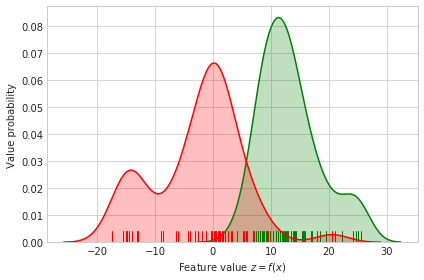

In [661]:
a = sns.distplot(zs[ys > .5], rug=True, hist=False, color='g', kde_kws={'shade': True});
sns.distplot(zs[ys < .5], rug=True, hist=False, color='r', kde_kws={'shade': True}, ax=a);

plt.xlabel('Feature value $z = f(x)$')
plt.ylabel('Value probability')
plt.tight_layout()

We can measure our classification performance by means of precision and recall.

- Recall is the percentage of faces in the dataset that were correctly identified as such; it penalizes false negatives.
- Precision is the percentage of correctly identified positives; it penalizes false positives.

Since both precision and recall change with the threshold we select, we can obtain a Precision-Recall curve that tells us how precision and recall change, given a specific threshold.

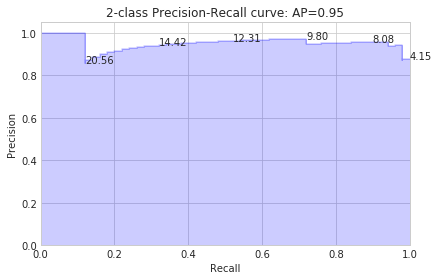

In [662]:
average_precision = average_precision_score(ys, zs)
precision, recall, thresholds = precision_recall_curve(ys, zs)

plt.step(recall, precision, color='b', alpha=0.2, where='post');
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

for i, (p, r, t) in enumerate(zip(precision, recall, thresholds)):
    if i % 10 == 0:
        plt.annotate(f'{t:.2f}', xy=(r, p))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.tight_layout()

It appears as if $8.08$ is a threshold that simultaneously maximizes precision and recall. Let's have a look at the precision and recall values, as well as the confusion matrix for this threshold.

In [575]:
PredictionStats = NamedTuple('PredictionStats', [('tn', int), ('fp', int), ('fn', int), ('tp', int)])

def prediction_stats(y_true: np.ndarray, y_pred: np.ndarray) -> Tuple[np.ndarray, PredictionStats]:
    c = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = c.ravel()
    return c, PredictionStats(tn=tn, fp=fp, fn=fn, tp=tp)

We find that our precision is indeed at 96% with a recall of 88%, i.e. 88% of all faces were correctly identified and we were 96% correct when we decided an image contains a face.

In [663]:
theta = 8.08
c, s = prediction_stats(ys, zs >= theta)

print(f'Precision {s.tp/(s.tp+s.fp):.2}, recall {s.tp/(s.tp+s.fn):.2}.')

Precision 0.96, recall 0.88.


When we look at the confusion matrix well see that specifically we predicted "face" 2 times when it actually wasn't a face (approximately 4.3% of the time, or $1 - precision$) and predicted "background" 6 times when it actually was a face (about 11.1%, the [false ommission rate](https://en.wikipedia.org/wiki/Positive_and_negative_predictive_values#false_omission_rate)). 

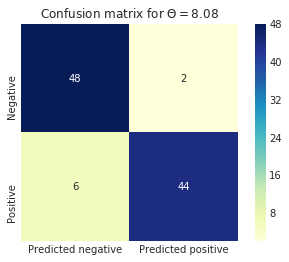

In [664]:
sns.heatmap(c, cmap='YlGnBu', annot=True, square=True, 
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title(f'Confusion matrix for $\Theta={theta}$');

This looks like it is indeed a good threshold value for the picked sample; however, we need to find the actual minimizer algorithmically.

Let's sort the results according to their value:

In [665]:
p = np.argsort(zs)
zs = zs[p]
ys = ys[p]

Ignoring weights - a property of AdaBoost - we can obtain running sums of the ("weighted") feature responses while passing once over the sorted list.

In [680]:
s_minuses, s_pluses = [], []
s_minus, s_plus = 0., 0.
t_minus, t_plus = 0., 0.

for z, y in zip(zs, ys):
    if y == 0:
        s_minus += 1
        t_minus += 1
    else:
        s_plus += 1
        t_plus += 1
    s_minuses.append(s_minus)
    s_pluses.append(s_plus)

If we plot the running sums we already start to see a pattern emerge:

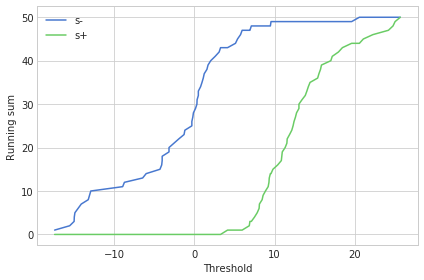

In [681]:
plt.figure()
plt.plot(zs, s_minuses)
plt.plot(zs, s_pluses)
plt.legend(['s-', 's+'])
plt.xlabel('Threshold')
plt.ylabel('Running sum')
plt.tight_layout();

Given the running sums $S^+$ and $S^-$, as well as the total sums $T^+$ and $T^-$, the goal is to minimize the error $e$ such that

$$
\epsilon = \min\left( S^+ + \left(T^- - S^-\right) \quad,\quad S^- + \left(T^+ - S^+\right) \right).
$$

The first term, $S^+ + \left(T^- - S^-\right)$, is associated with the error of labelling all items below this threshold as "negative" (implying a detector polarity of $-1$), while labelling all above as "positive" and vice versa (i.e. a polarity of $+1$).

While doing so, we keep track of the individual values for displaying purposes:

In [682]:
errors_1, errors_2 = [], []

min_e = float('inf')
min_idx = 0
polarity = 0
for i, (s_m, s_p) in enumerate(zip(s_minuses, s_pluses)):
    error_1 = s_p + (t_minus - s_m)
    error_2 = s_m + (t_plus - s_p)
    errors_1.append(error_1)
    errors_2.append(error_2)
    
    if error_1 < min_e:
        min_e = error_1
        min_idx = i
        polarity = -1
    elif error_2 < min_e:
        min_e = error_2
        min_idx = i
        polarity = 1
        
print(f'Minimal error: {min_e:.2} at index {min_idx} with threshold {zs[min_idx]:.2}. Classifier polarity is {polarity}.')

Minimal error: 4.0 at index 47 with threshold 6.0. Classifier polarity is -1.


Interestingly, this selects threshold $6$ as the best value at a polarity of $-1$, implying that all results below are negative and examples above the threshold (possibly) positive. We can also see this in the following plot.

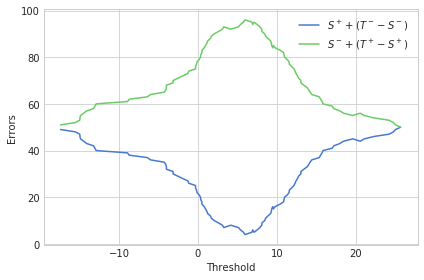

In [683]:
plt.figure()
plt.plot(zs, errors_1)
plt.plot(zs, errors_2)
plt.legend(['$S^+ + (T^- - S^-)$', '$S^- + (T^+ - S^+)$', '?'])
plt.xlabel('Threshold')
plt.ylabel('Errors')
plt.tight_layout();

When we re-evaluate precision and recall, as well as the confusion matrix for this choice, we find that while we're indeed performing quite good, with a precision of 92% (we predicted "face" four times when it actually was a background). Predicting "background" when it actually was a face clocked us in at a false positive rate of about 8%.

Precision 0.92, recall 0.98, false positive rate 0.08.


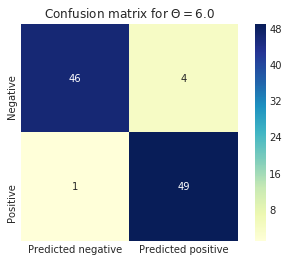

In [685]:
theta = zs[min_idx]
c, s = prediction_stats(ys, zs >= theta)

sns.heatmap(c, cmap='YlGnBu', annot=True, square=True, 
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title(f'Confusion matrix for $\Theta={theta:.2}$');

print(f'Precision {s.tp/(s.tp+s.fp):.2}, recall {s.tp/(s.tp+s.fn):.2}, false positive rate {s.fp/(s.fp+s.tn)}.')

It is the job of AdaBoost to take this information to its (and our) advantage.

# Adaptive Boosting

In [765]:
random.seed(18151210)
xs, ys = sample_data_normalized(500, 700)

Again, we're going to need the integral images:

In [766]:
xis = np.array([to_integral(x) for x in xs])
xs.shape, xis.shape

((1200, 24, 24), (1200, 25, 25))

In [704]:
ClassifierResult = NamedTuple('ClassifierResult', [('threshold', float), ('polarity', int), 
                                                   ('classification_error', float), ('threshold_error', float), 
                                                   ('classifier', Callable[[np.ndarray], float])])

WeakClassifier = NamedTuple('WeakClassifier', [('threshold', float), ('polarity', int), 
                                               ('alpha', float), 
                                               ('classifier', Callable[[np.ndarray], float])])


def strong_classifier(weak_classifiers: List[WeakClassifier], x: np.ndarray) -> int:
    sum_alphas = 0.
    sum_hypotheses = 0.
    for c in weak_classifiers:
        sum_alphas += c.alpha
        h = 1 if (c.polarity*c.classifier(x) < c.polarity*c.threshold) else 0
        sum_hypotheses = c.alpha * h
    return 1 if (sum_hypotheses > .5*sum_alphas) else 0

In [818]:
def normalize_weights(w: np.ndarray) -> np.ndarray:
    return w / w.sum()


def apply_feature(f: Callable[[np.ndarray], float], xis_: np.ndarray, ys_: np.ndarray, ws_: np.ndarray) -> ClassifierResult:
    assert xis_.shape[1:3] == (25, 25), xis_.shape
    
    zs = np.array([f(x) for x in xis_])
    p = np.argsort(zs)
    zs, ys, ws = zs[p], ys_[p], ws_[p]
    
    # Determine the best threshold: build running sums
    s_minuses, s_pluses = [], []
    s_minus, s_plus = 0., 0.
    t_minus, t_plus = 0., 0.
    for y, w in zip(ys, ws):
        if y == 0:
            s_minus += w
            t_minus += w
        else:
            s_plus += w
            t_plus += w
        s_minuses.append(s_minus)
        s_pluses.append(s_plus)
    
    # Determine the best threshold: select optimal threshold.
    min_e = float('inf')
    min_z, polarity = 0, 0
    for z, s_m, s_p in zip(zs, s_minuses, s_pluses):
        error_1 = s_p + (t_minus - s_m)
        error_2 = s_m + (t_plus - s_p)
        if error_1 < min_e:
            min_e = error_1
            min_z = z
            polarity = -1
        elif error_2 < min_e:
            min_e = error_2
            min_z = z
            polarity = 1
            
    # Determine the classification error
    classification_error = 0.
    for x, y, w in zip(xis, ys, ws):
        h = 1 if (polarity*f(x) < polarity*min_z) else 0
        classification_error += w * np.abs(h - y)
            
    return ClassifierResult(threshold=min_z, polarity=polarity, threshold_error=min_e, 
                            classification_error=classification_error, classifier=f)
    
    
def build_weak_classifiers(T: int, xis: np.ndarray, ys: np.ndarray) -> List[WeakClassifier]:
    m = len(ys[ys > .5])  # number of positive example
    n = len(ys[ys < .5])  # number of negative examples

    ws = np.zeros_like(ys)
    ws[ys < .5] = 1/(2*m)
    ws[ys > .5] = 1/(2*n)

    weak_classifiers = []  # type: List[WeakClassifier]
    for t in range(T):
        print(f'Building weak classifier {t+1}/{T} ...')
        ws = normalize_weights(ws)

        # Select best weak classifier
        best = ClassifierResult(polarity=0, threshold=0, threshold_error=float('inf'),
                                classification_error=float('inf'), classifier=None)
        status_every, status_counter = 4000, 4000
        skip_counter = 4
        for i, f in enumerate(features):
            status_counter -= 1
            skip_counter -= 1
            improved = False
                        
            # Python runs singlethreaded. To speed things up,
            # we're only anticipating every other feature, give or take.
            if skip_counter != 0:
                continue
            skip_counter = 4
            
            result = apply_feature(f, xis, ys, ws)
            if result.classification_error < best.classification_error:
                improved = True
                best = result
                
            # Print status every couple of iterations.
            if status_counter == 0 or improved:
                status_counter = status_every
                print(f't={t+1}/{T} {i+1}/{len(features)} {100*i/len(features):.2}% of detectors evaluated. Best classification error: {best.classification_error:.5} ...')

        beta = best.classification_error / (1 - best.classification_error)
        weak_classifiers.append(WeakClassifier(threshold=best.threshold, polarity=best.polarity, 
                                               classifier=best.classifier, alpha=1./np.log(beta)))

        # Update weights
        for i, (x, y) in enumerate(zip(xis, ys)):
            h = 1 if (best.polarity*best.classifier(x) < best.polarity*best.threshold) else 0
            e = 0 if (h == y) else 1
            ws[i] = ws[i]*beta**(1-e)
    
    return weak_classifiers


assert xis.shape[1:3] == (25, 25), xis.shape
weak_classifiers = build_weak_classifiers(2, xis, ys)

Building weak classifier 1/2 ...
t=1/2 4/108300 0.0028% of detectors evaluated. Best classification error: 0.33649 ...
t=1/2 128/108300 0.12% of detectors evaluated. Best classification error: 0.3073 ...
t=1/2 148/108300 0.14% of detectors evaluated. Best classification error: 0.30257 ...
t=1/2 656/108300 0.6% of detectors evaluated. Best classification error: 0.2877 ...
t=1/2 676/108300 0.62% of detectors evaluated. Best classification error: 0.26959 ...
t=1/2 684/108300 0.63% of detectors evaluated. Best classification error: 0.26757 ...
t=1/2 748/108300 0.69% of detectors evaluated. Best classification error: 0.25581 ...
t=1/2 2092/108300 1.9% of detectors evaluated. Best classification error: 0.24946 ...
t=1/2 2488/108300 2.3% of detectors evaluated. Best classification error: 0.22027 ...
t=1/2 3696/108300 3.4% of detectors evaluated. Best classification error: 0.2073 ...
t=1/2 4968/108300 4.6% of detectors evaluated. Best classification error: 0.19459 ...
t=1/2 8080/108300 7.5% of

In [827]:
ys_1 = np.array([strong_classifier([weak_classifiers[0]], x) for x in xis])
c, s = prediction_stats(ys, ys_1)
c, s

(array([[ 20, 680],
        [435,  65]]), PredictionStats(tn=20, fp=680, fn=435, tp=65))

In [826]:
# TODO: Ratio with just one classifier?
ys_2 = np.array([strong_classifier(weak_classifiers, x) for x in xis])
c, s = prediction_stats(ys, ys_2)
c, s

(array([[ 67, 633],
        [449,  51]]), PredictionStats(tn=67, fp=633, fn=449, tp=51))